# План решения

1. Объединить train и test для совместной обработки.
2. Убрать выбросы (0.05 и 0.95 перцентили)
3. Создать признаки:<br>
    -есть ли: 
        - буква верхнего регистра
        - буква нижнего регистра
        - специальный символ
        - цифра
    -состоит ли пароль только из:
        - цифр
        - букв верхнего регистра
        - букв нижнего регистра
    -количество символов 

In [1]:
import time
import math
import numpy as np
import pandas as pd
import scipy as sc
from scipy.optimize import minimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import normaltest, skewtest, probplot, boxcox
#from scipy.stats import hstack, vstack

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import mean_squared_log_error



## Get data

In [2]:
df = pd.read_csv("train.csv", delimiter=',')

# EDA

In [40]:
df.head()

,Password,Times
0,631XniVx2lS5I,2
1,LEGIT747,1
2,742364es,1
3,3846696477,1
4,laurahop,2


In [5]:
df.shape

(4151496, 2)

In [6]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151496 entries, 0 to 4151495
Data columns (total 2 columns):
Password    4151494 non-null object
Times       4151496 non-null int64
dtypes: int64(1), object(1)
memory usage: 63.3+ MB


In [138]:
# Check Nun values
df.isnull().sum()

Password    2
Times       0
dtype: int64

## Предобработка данных

In [3]:
# Delete NuN data
df.dropna(axis=0, inplace = True)

In [8]:
# Check Nun values
df.isnull().sum()

Password    0
Times       0
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,Password,Times


## Создание признаков

In [49]:
df.head()

,Password,Times,len
0,631XniVx2lS5I,2,13
1,LEGIT747,1,8
2,742364es,1,8
3,3846696477,1,10
4,laurahop,2,8


In [4]:
# Get the len of passwords
df['len'] = df['Password'].map(lambda x : len(x))

In [5]:
# Получим новые признаки нижний, верхний. смешенные регистры и является ли пароль только числовым
df['islower'] = df['Password'].map(lambda x: 1 if x.islower() else 0)
df['isupper'] = df['Password'].map(lambda x: 1 if x.isupper() else 0)
df['is_not_lower_not_upper'] = df['Password'].map(lambda x: 1 if not x.islower() and not x.isupper() else 0)
df['isnumeric'] = df['Password'].map(lambda x: 1 if x.isnumeric() else 0)

In [65]:
df.head()

,Password,Times,len,islower,isupper,is_not_lower_not_upper,isnumeric
0,631XniVx2lS5I,2,13,0,0,1,0
1,LEGIT747,1,8,0,1,0,0
2,742364es,1,8,1,0,0,0
3,3846696477,1,10,0,0,1,1
4,laurahop,2,8,1,0,0,0


In [66]:
df['Password'].loc[0]

'631XniVx2lS5I'

## Выбор метрики

In [113]:
def rmsle(y, y_pred):
    y_pred = np.exp(y_pred) - 1 
    return np.sqrt(mean_squared_log_error(y, y_pred))

### Исследование распределения целевой переменной

CPU times: user 1.41 s, sys: 571 ms, total: 1.98 s
Wall time: 1.98 s


((array([-5.10321764, -4.93280962, -4.84093357, ...,  4.84093357,
          4.93280962,  5.10321764]),
  array([    1,     1,     1, ..., 11696, 13137, 55893])),
 (2.4776953796970913, 1.922126347767816, 0.07623457182307185))

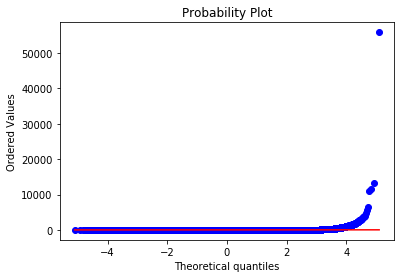

In [28]:
%%time
probplot(df['Times'], dist='norm', plot=plt);

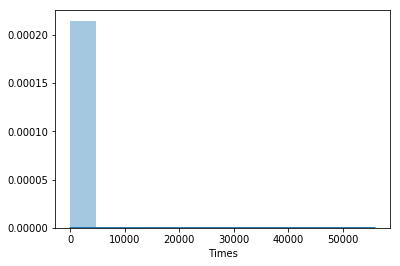

In [25]:
sns.distplot(df['Times'], bins=12);

CPU times: user 1.51 s, sys: 684 ms, total: 2.19 s
Wall time: 2.19 s


((array([-5.10321764, -4.93280962, -4.84093357, ...,  4.84093357,
          4.93280962,  5.10321764]),
  array([ 0.        ,  0.        ,  0.        , ...,  9.36700218,
          9.48318796, 10.93119443])),
 (0.33832190722993527, 0.18230045079124824, 0.6195206654729174))

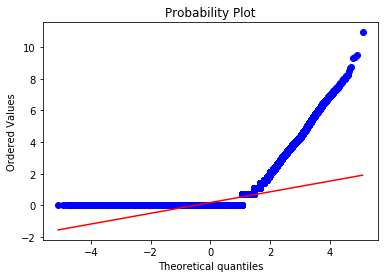

In [29]:
%%time
probplot(np.log(df['Times']), dist='norm', plot=plt);

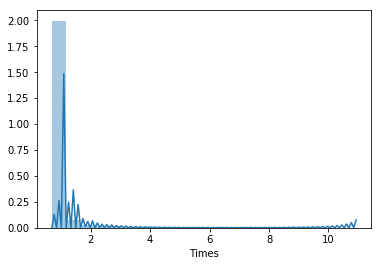

In [33]:
sns.distplot(np.log(df['Times']+1), bins=22);

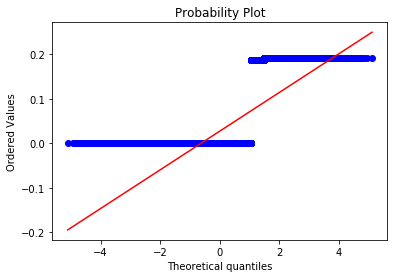

In [34]:
df['bc_avg_rating'], bc_lmbda = boxcox(df['Times'])
probplot(df['bc_avg_rating'], dist='norm', plot=plt);

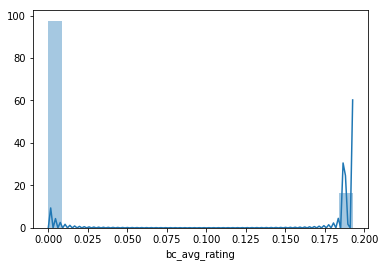

In [35]:
sns.distplot(df['bc_avg_rating'], bins=22);

In [36]:
np.log(5)

1.6094379124341003

In [37]:
np.exp(1.6094379124341003)

4.999999999999999

## Baseline модели

### 4.1 Константное предсказание

In [12]:
y = df['Times']
Const = np.exp(np.sum(np.log(y+1))/y.shape[0])-1

In [154]:
print("Константное предсказание",Const)

Константное предсказание 1.2654335284596323


In [158]:
# Score = 0.41230

### 4.2 Предсказание модели

In [6]:
y = np.log(df['Times']+1)
X = df.drop(['Times', 'Password'], axis = 1)

In [19]:
# Make train test split...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Кроссвалидация

In [20]:
# Models 
regr = RandomForestRegressor(max_depth=5, random_state=42, n_estimators=300)

In [112]:
%%time
score = -np.mean(cross_val_score(regr, X_train, y_train, cv=3, scoring='neg_mean_squared_log_error'))
print(np.sqrt(score))

KeyboardInterrupt: 

In [ ]:
0.4874924097007002

In [ ]:
c log 0.29164880759189066

In [93]:
x = 5
np.log(x+1)

1.791759469228055

In [95]:
np.exp(1.791759469228055) - 1

5.0

In [99]:
df['Times'].head()

0    2
1    1
2    1
3    1
4    2
Name: Times, dtype: int64

In [97]:
df['Times'].head() + 1

0    3
1    2
2    2
3    2
4    3
Name: Times, dtype: int64

## Прогноз на отложенной выборке

In [21]:
def rmsle(y, y_pred):
    y_pred = np.exp(y_pred) - 1 
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [22]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
pred = regr.predict(X_test)
print("Скор на отложенной выборке: ", rmsle(y_test, pred))

Скор на отложенной выборке:  0.28966607061562627


In [ ]:
Скор на отложенной выборке:  0.4866668567795322

## Подготовка subbmission

In [8]:
%%time
# Обучим модель на всех данных
regr.fit(X,y)

CPU times: user 15min 29s, sys: 142 ms, total: 15min 30s
Wall time: 15min 29s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
test = pd.read_csv("Xtest.csv", delimiter=',')

In [ ]:
test.shape

In [ ]:
test.head()

In [ ]:
test.isna().sum()

In [10]:
test['Password'].fillna('unknown', inplace=True)

In [11]:
# Get the len of passwords
test['len'] = test['Password'].map(lambda x : len(x))
test['islower'] = test['Password'].map(lambda x: 1 if x.islower() else 0)
test['isupper'] = test['Password'].map(lambda x: 1 if x.isupper() else 0)
test['is_not_lower_not_upper'] = test['Password'].map(lambda x: 1 if not x.islower() and not x.isupper() else 0)
test['isnumeric'] = test['Password'].map(lambda x: 1 if x.isnumeric() else 0)

In [15]:
%%time
y_pred = regr.predict(test.drop(['Id', 'Password'], axis=1))

In [16]:
def save_prediction(y_pred, test):
    df_res = test[['Id']]
    df_res['Times'] = np.exp(y_pred) - 1
    df_res.to_csv('submission_log.csv', sep=',', index=None)

In [17]:
%%time
save_prediction(y_pred, test)

/opt/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 3.9 s, sys: 66.1 ms, total: 3.97 s
Wall time: 3.96 s


In [196]:
submission = pd.read_csv('submission_log.csv')
submission.head()

,Id,Times
0,0,1.187189
1,1,1.187189
2,2,1.187189
3,3,2.934471
4,4,1.909209


In [18]:
submission = pd.read_csv('submission_log.csv')
submission.head()

,Id,Times
0,0,1.058743
1,1,1.081946
2,2,1.101608
3,3,1.449993
4,4,1.316614


In [18]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [25]:
# Make train_test_split 
X = data['Password']
y = data['Times']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
# Models 
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)

In [37]:
# Cross_validation
cross_val_score(regr, X, y, scoring='neg_mean_squared_log_error', cv=2) 

/home/evpolnik/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: 'eliardcs199'

In [40]:
X.head()

0    631XniVx2lS5I
1         LEGIT747
2         742364es
3       3846696477
4         laurahop
Name: Password, dtype: object

In [36]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [20]:

regr.fit(X, y)  

In [16]:
max(data["Times"])

55893

In [17]:
data[data['Times']==55893].head()

,Password,Times
2715397,123456,55893


In [14]:
data['Times'].value_counts()

1       3547155
2        309205
3         96462
4         47704
5         27903
6         18627
7         13635
8         10567
9          8235
10         6775
11         5546
12         4818
13         4175
14         3565
15         3111
16         2699
17         2553
18         2222
19         2002
20         1887
21         1774
22         1578
23         1483
24         1388
25         1243
26         1152
27         1099
29          963
28          928
30          875
         ...   
588           1
585           1
583           1
580           1
578           1
577           1
575           1
574           1
573           1
572           1
607           1
616           1
658           1
2665          1
657           1
654           1
652           1
649           1
648           1
647           1
645           1
639           1
637           1
632           1
628           1
626           1
621           1
618           1
617           1
406           1
Name: Times, Length: 823